<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/main/High_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке развивается предсказатель высшей точки. Его цель - предсказывать, что мы находимя в локлаьном максимуме - цены выше на заданном горизонте в будущем не будет

In [2]:
#!pip install yfinance

In [50]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from methods import load_data

In [78]:
stocks = load_data("msft", period_start="2021-01-01")
stocks.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,220.224826,220.689959,212.584796,215.434967,37130100
2021-01-05,215.009407,216.256364,213.465569,215.642776,23823000
2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700
2021-01-07,211.822773,217.067874,211.496205,216.028748,27694500
2021-01-08,216.414721,218.295048,214.781819,217.344986,22956200


# Размечаем таргет

In [79]:
def mark_target(prices, window=10):
  """Размечаем фактические точки лоу и хай"""
  maxes = stocks["Close"].rolling(window=window, center=True).max()

  targets = np.zeros_like(prices)
  targets[prices==maxes]=1
  return targets

targets = mark_target(stocks["Close"])
stocks["target"] = targets

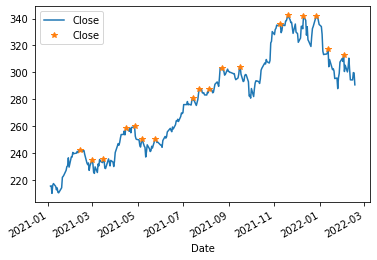

In [80]:
stocks["Close"].plot()
stocks.loc[stocks["target"]==1, "Close"].plot(style="*")
plt.legend()

# Скользящие средние?

In [83]:
def create_ma(prices, ma_steps=[5,10,15,20]):
  result=pd.DataFrame()
  result["price"] = prices
  for ma_step in ma_steps:
    ma = prices.rolling(ma_step).mean()
    result["ma_{}".format(ma_step)] = ma
  return result

In [91]:
stock_ma = create_ma(stocks["Close"], ma_steps=[30, 60])

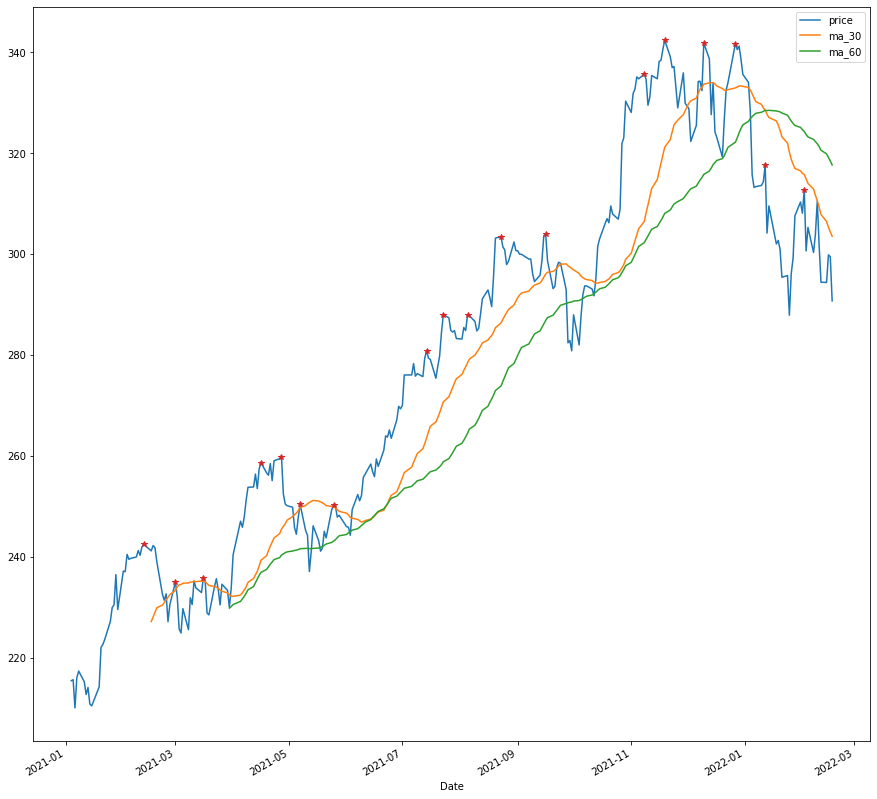

In [93]:
stock_ma.plot(figsize=[15,15])
stocks.loc[stocks["target"]==1, "Close"].plot(style="*")

In [38]:
np.zeros()[prices==maxes]

Date
1986-03-13    False
1986-03-14    False
1986-03-17    False
1986-03-18    False
1986-03-19    False
              ...  
2022-02-11    False
2022-02-14    False
2022-02-15    False
2022-02-16    False
2022-02-17    False
Name: Close, Length: 9059, dtype: bool

In [36]:
t[-10:]

Date
2022-02-04    312.813171
2022-02-07    312.813171
2022-02-08    312.813171
2022-02-09    312.813171
2022-02-10    310.567810
2022-02-11    310.567810
2022-02-14           NaN
2022-02-15           NaN
2022-02-16           NaN
2022-02-17           NaN
Name: Close, dtype: float64

In [21]:
len(t)

9059

In [14]:
stocks["Close"]

Date
1986-03-13      0.061252
1986-03-14      0.063439
1986-03-17      0.064533
1986-03-18      0.062892
1986-03-19      0.061799
                 ...    
2022-02-11    294.431213
2022-02-14    294.391296
2022-02-15    299.850006
2022-02-16    299.500000
2022-02-17    290.730011
Name: Close, Length: 9059, dtype: float64